In [3]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
print("Imports Successful")


Imports Successful


In [4]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U


In [5]:
n_count = 8  
a = 7


In [6]:
def qft_dagger(n):
    qc = QuantumCircuit(n)
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc


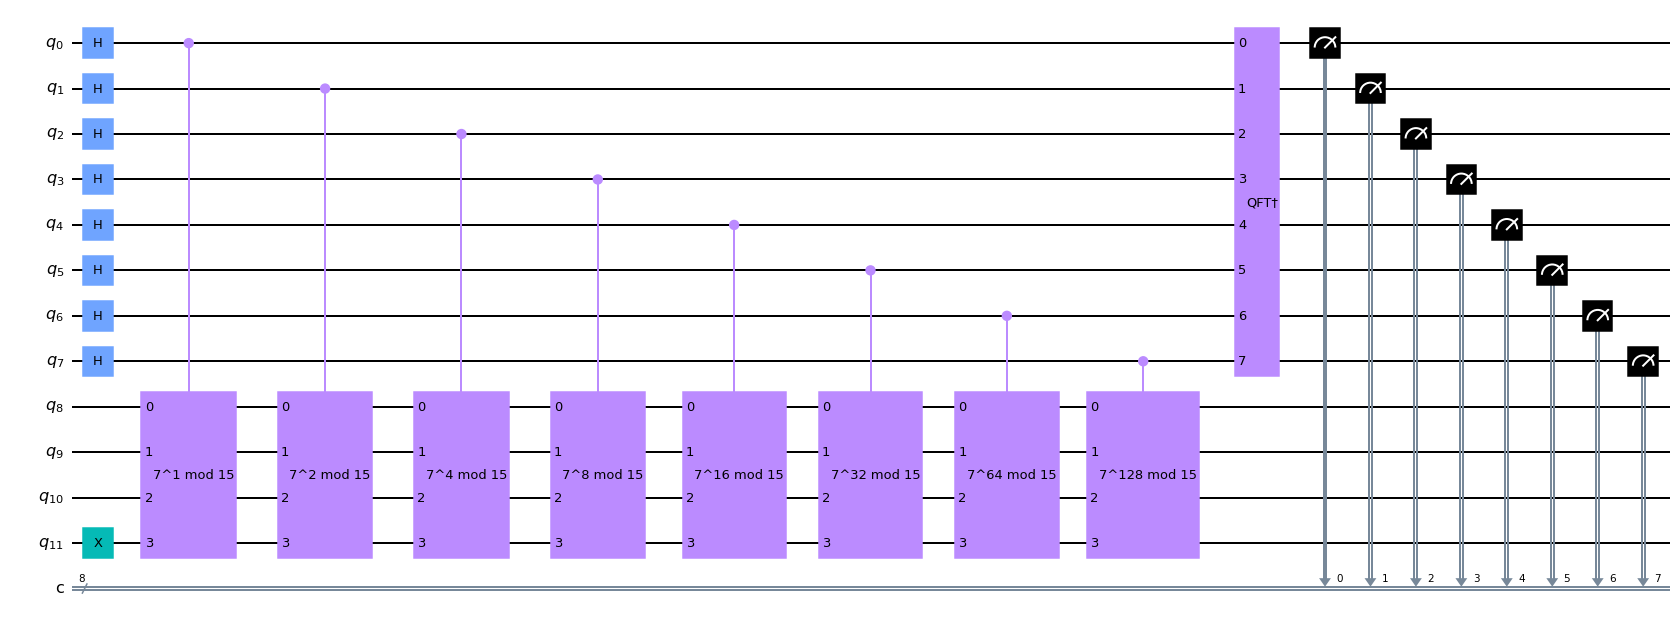

In [7]:

qc = QuantumCircuit(n_count + 4, n_count)

for q in range(n_count):
    qc.h(q)
    
qc.x(3+n_count)

for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

qc.append(qft_dagger(n_count), range(n_count))

qc.measure(range(n_count), range(n_count))
qc.draw(fold=-1)  


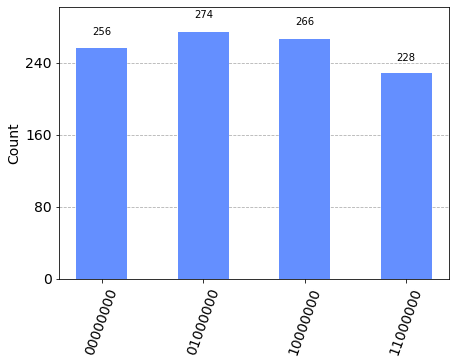

In [8]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)


In [9]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  
    phase = decimal/(2**n_count) 
    measured_phases.append(phase)
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)


            Register Output           Phase
0  10000000(bin) = 128(dec)  128/256 = 0.50
1  00000000(bin) =   0(dec)    0/256 = 0.00
2  01000000(bin) =  64(dec)   64/256 = 0.25
3  11000000(bin) = 192(dec)  192/256 = 0.75


In [10]:
Fraction(0.666)


Fraction(5998794703657501, 9007199254740992)

In [11]:

Fraction(0.666).limit_denominator(15)


Fraction(2, 3)

In [12]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)


   Phase Fraction  Guess for r
0   0.50      1/2            2
1   0.00      0/1            1
2   0.25      1/4            4
3   0.75      3/4            4


In [13]:
def a2jmodN(a, j, N):
    """Compute a^{2^j} (mod N) by repeated squaring"""
    for i in range(j):
        a = np.mod(a**2, N)
    return a


In [14]:
a2jmodN(7, 2049, 53)


47

In [15]:
N = 15


In [16]:
np.random.seed(1) 
a = randint(2, 15)
print(a)


7


In [17]:
from math import gcd 
gcd(a, N)


1

In [18]:
def qpe_amod15(a):
    n_count = 8
    qc = QuantumCircuit(4+n_count, n_count)
    for q in range(n_count):
        qc.h(q)     
    qc.x(3+n_count) 
    for q in range(n_count): 
        qc.append(c_amod15(a, 2**q), 
                 [q] + [i+n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count)) 
    qc.measure(range(n_count), range(n_count))
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc, shots=1)
    result = aer_sim.run(qobj, memory=True).result()
    readings = result.get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase


In [19]:
phase = qpe_amod15(a) 
Fraction(phase).limit_denominator(15) 


Register Reading: 10000000
Corresponding Phase: 0.500000


Fraction(1, 2)

In [20]:
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)


2


In [21]:
a = 7
factor_found = False
attempt = 0
while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    frac = Fraction(phase).limit_denominator(N) 
    r = frac.denominator
    print("Result: r = %i" % r)
    if phase != 0:
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: 
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True



Attempt 1:
Register Reading: 10000000
Corresponding Phase: 0.500000
Result: r = 2
Guessed Factors: 3 and 1
*** Non-trivial factor found: 3 ***
